# Importando bibliotecas

In [13]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import warnings
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Activation
from tensorflow.keras.layers import concatenate, Rescaling
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings('ignore')
%matplotlib inline

---
# Preparando dos dados

In [14]:
image_size = (128, 128)
batch_size = 4

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Train",
    seed=2022,
    class_names=["Female_reduzida", "Male_reduzida"],
    image_size=image_size,
    batch_size=batch_size,
)

Found 39999 files belonging to 2 classes.


In [15]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Test",
    seed=2022,
    class_names=["Female", "Male"],
    image_size=image_size,
    batch_size=batch_size,
)

Found 20000 files belonging to 2 classes.


In [16]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Validation",
    seed=2022,
    class_names=["Female", "Male"],
    image_size=image_size,
    batch_size=batch_size,
)

Found 22598 files belonging to 2 classes.


In [ ]:
for img, lbl in train_ds.take(1):
    for i, l in zip(img, lbl):
        plt.imshow(i.numpy().astype("uint8"))
        plt.title(str(l.numpy()))
        plt.show()
    break

---
# Criando e treinando o modelo

In [18]:
def resblock(input_layer, filters):
    initial_layer = MaxPool2D(2)(input_layer)
    forward = Conv2D(filters, (3, 3), padding="same") (input_layer)
    forward = MaxPool2D(2)(forward)
    output_layer = concatenate([initial_layer, forward])
    return output_layer

def create_model(input_size, output_classes):
    input_layer = Input(shape=(input_size))
    forward = Rescaling(1.0 / 255)(input_layer)
    filters = 32
    
    forward = Conv2D(filters, (3, 3), padding="same", activation="relu") (forward)
    forward = MaxPool2D(2)(forward)
    
    for _ in range(4):
        forward = resblock(forward, filters)
        filters *= 2
    
    forward = Flatten()(forward)
    forward = Dense(output_classes, activation="sigmoid")(forward)
    model = Model(input_layer, forward)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["acc"])
    return model

In [19]:
model = create_model(input_size=(128, 128, 3), output_classes=1)

In [20]:
history = model.fit(train_ds, validation_data=valid_ds, epochs=10, shuffle=True)

Epoch 1/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1168s 117ms/step - acc: 0.8601 - loss: 0.3096 - val_acc: 0.9540 - val_loss: 0.1165
Epoch 2/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 923s 92ms/step - acc: 0.9609 - loss: 0.1051 - val_acc: 0.9607 - val_loss: 0.1002
Epoch 3/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1192s 119ms/step - acc: 0.9732 - loss: 0.0720 - val_acc: 0.9684 - val_loss: 0.0855
Epoch 4/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1067s 107ms/step - acc: 0.9835 - loss: 0.0469 - val_acc: 0.9660 - val_loss: 0.1042
Epoch 5/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 838s 84ms/step - acc: 0.9912 - loss: 0.0277 - val_acc: 0.9641 - val_loss: 0.1220
Epoch 6/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 836s 84ms/step - acc: 0.9939 - loss: 0.0186 - val_acc: 0.9688 - val_loss: 0.1212
Epoch 7/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 973s 97ms/step - acc: 0.9954 - loss: 0.0156 - val_acc: 0.9697 - val_loss: 0.1253
Epoch 8/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 840s 84ms/step - acc: 0.9964 - loss: 0.0098 - val_acc: 0.9684 - val_loss: 0

---
# Salvando modelo

In [11]:
model.save('cnn_treinada.keras')  


---
# Gerando imagens e métricas e plotando gráficos

In [5]:
model = tf.keras.models.load_model('cnn_treinada.keras') 
classes = {0: "Female",
1: "Male"}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


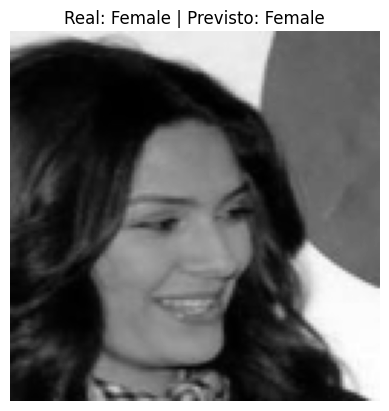

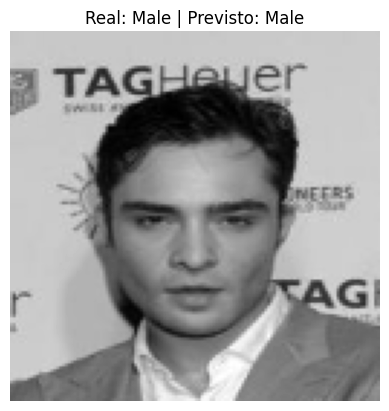

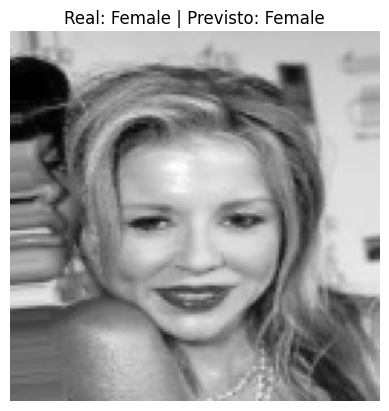

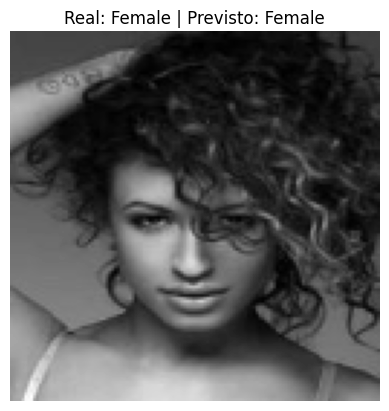

In [29]:
test_ds = test_ds.shuffle(buffer_size=len(test_ds))

for images, labels in test_ds:
    pred = model.predict(images)
    for i, r, p in zip(images, labels, pred):
        p = np.round(p[0])
        i_gray = np.dot(i.numpy()[..., :3], [0.2989, 0.5870, 0.1140])
        if r == 0: real = "Female"
        else: real = "Male"

        plt.imshow(i_gray, cmap='gray')
        plt.title(f'Real: {real} | Previsto: {classes[p]}')
        plt.axis('off')
        plt.show()
    break

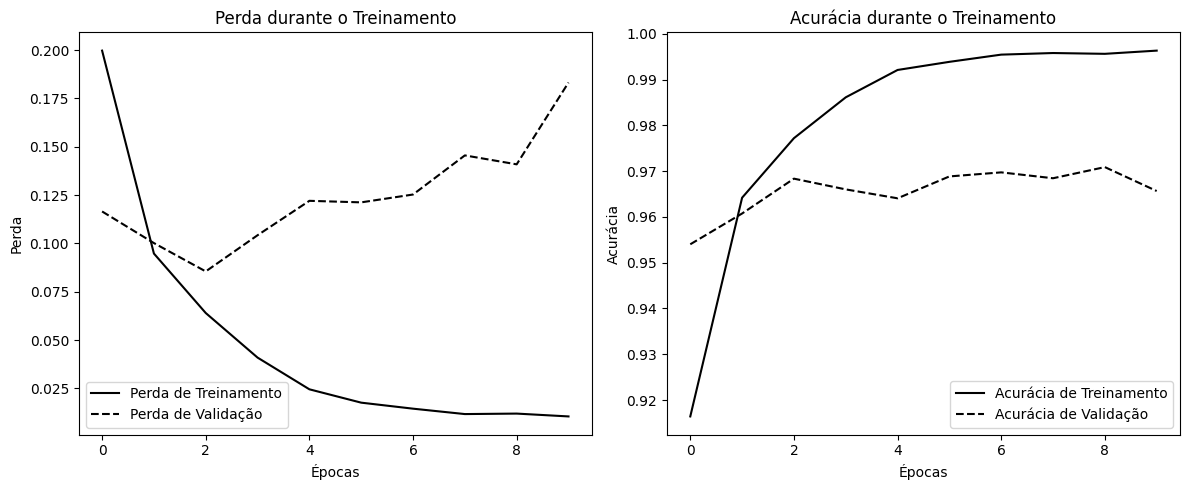

In [23]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']  
val_acc = history.history['val_acc']


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Perda de Treinamento', color='black')
plt.plot(val_loss, label='Perda de Validação', color='black', linestyle='dashed')
plt.title('Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Acurácia de Treinamento', color='black')
plt.plot(val_acc, label='Acurácia de Validação', color='black', linestyle='dashed')
plt.title('Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# Primeira iteração para obter y_true
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.append(labels.numpy())  # Armazena os rótulos verdadeiros
    pred = model.predict(images)   # Faz a predição
    pred = np.round(pred).astype(int)  # Arredonda a predição para 0 ou 1
    y_pred.append(pred)

# Concatena e ajusta as previsões
y_true = np.concatenate(y_true)
y_true = [classes[label] for label in y_true]

y_pred = np.concatenate(y_pred).flatten()
y_pred = [classes[pred] for pred in y_pred]

# Gera o relatório de classificação
report = classification_report(y_true, y_pred, target_names=list(classes.values()))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

In [12]:
print(report)

              precision    recall  f1-score   support

      Female       0.98      0.97      0.98     11541
        Male       0.96      0.98      0.97      8459

    accuracy                           0.98     20000
   macro avg       0.97      0.98      0.97     20000
weighted avg       0.98      0.98      0.98     20000



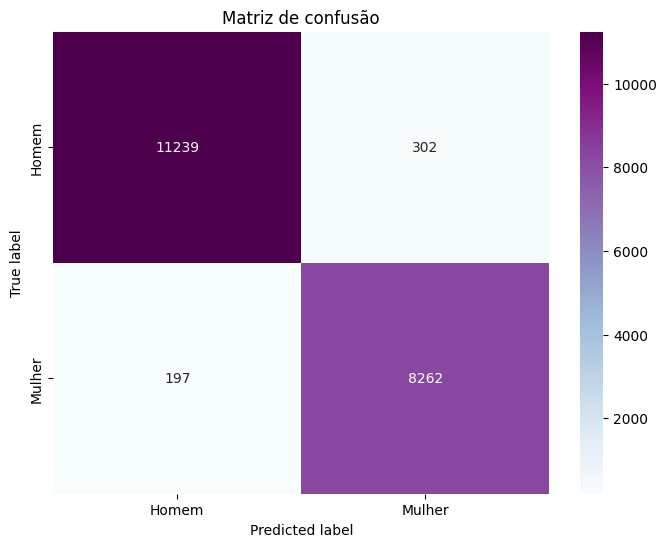

In [15]:
matriz = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(matriz, annot=True, fmt='d', cmap='BuPu', xticklabels=['Homem', 'Mulher'], yticklabels=['Homem', 'Mulher'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Matriz de confusão')
plt.show()

In [28]:
test_loss, test_accuracy = model.evaluate(test_ds)

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 96s 19ms/step - acc: 0.9666 - loss: 0.1740


In [27]:
print(test_accuracy)

0.9666000008583069
